In [1]:
"""
Gather event- and daily-level FIRED polygons for western U.S. ecoregions
Author: maxwell.cook@colorado.edu
"""

import os, time, glob, gc
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime

import warnings
warnings.filterwarnings("ignore")
                        
proj = 'EPSG:5070'

maindir = '/Users/max/Library/CloudStorage/OneDrive-Personal/mcook/'
projdir = os.path.join(maindir, 'aspen-fire/Aim2/')

print("Ready !")

Ready !


In [6]:
# Load western U.S. ecoregions
fp = os.path.join(projdir,'data/spatial/mod/boundaries/na_cec_eco_l3_west.gpkg')
ecol3 = gpd.read_file(fp)
ecol3 = ecol3[['NA_L3NAME','geometry']]
ecol3 = ecol3.rename(columns={'NA_L3NAME': 'na_l3name'})
ecol3.columns

Index(['na_l3name', 'geometry'], dtype='object')

In [9]:
# Load the event FIRED polygons
fp = os.path.join(maindir,'FIRED/data/spatial/mod/events/fired-events_conus_ak_2000_to_2024_lambert.gpkg')
events = gpd.read_file(fp)
events['id'] = events['id'].astype(int)
events = events[(events['ig_year'] >= 2012) & (events['ig_year'] <= 2023)] # work with 2012-> VIIRS
events = events.to_crs(proj) # project to EPSG:5070

# Extract within western U.S. ecoregions (CONUS)
centroids = events.copy()
centroids.geometry = centroids.geometry.centroid # use the centroid for joining to ecoregions

assert centroids.crs == ecol3.crs, "CRS mismatch, fix it !"

events_west = gpd.overlay(centroids, ecol3, how='intersection') # find overlaps
events_west['ecol3_area'] = events_west.geometry.area / 1e6 # calculate overlap area
events_west = events_west.loc[
    events_west.groupby('id')['ecol3_area'].idxmax()
] # find the greatest overlapping ecoregion, return that row
events_west['ecol3_pct'] = round(events_west['ecol3_area'] / events_west['tot_ar_km2'], 3)

# Merge back to perimeter data
events_west_ = gpd.GeoDataFrame(events_west[['id', 'na_l3name']].merge(events, on='id', how='left'))

print(f"There are {len(events_west_)} unique fire events across western U.S. ecoregions in CONUS (2012-2023).")
print(f"Data columns:\n{events_west_.columns}")

There are 19455 unique fire events across western U.S. ecoregions in CONUS (2012-2023).
Data columns:
Index(['id', 'na_l3name', 'ig_date', 'ig_day', 'ig_month', 'ig_year',
       'last_date', 'event_dur', 'tot_pix', 'tot_ar_km2', 'fsr_px_dy',
       'fsr_km2_dy', 'mx_grw_px', 'mn_grw_px', 'mu_grw_px', 'mx_grw_km2',
       'mn_grw_km2', 'mu_grw_km2', 'mx_grw_dte', 'x', 'y', 'ig_utm_x',
       'ig_utm_y', 'lc_code', 'lc_mode', 'lc_name', 'lc_desc', 'lc_type',
       'eco_mode', 'eco_name', 'eco_type', 'tot_perim', 'geometry'],
      dtype='object')


In [10]:
# Handle the date fields before exporting
date_cols = ['ig_date', 'last_date', 'mx_grw_dte']
for col in date_cols:
    events_west_[col] = pd.to_datetime(events_west_[col], errors='coerce')
# Get rid of the land cover
cols_to_keep = ['id', 'ig_date', 'ig_day', 'ig_month', 'ig_year', 'last_date',
                'event_dur', 'tot_pix', 'tot_ar_km2', 'fsr_px_dy', 'fsr_km2_dy',
                'mx_grw_px', 'mx_grw_km2', 'mx_grw_dte', 'ig_utm_x', 'ig_utm_y', 
                'na_l3name', 'geometry']
events_west_ = events_west_[cols_to_keep]

# Save the file.
out_fp = os.path.join(projdir, 'data/spatial/raw/FIRED/fired-events_west_2012_to_2023.gpkg')
events_west_.to_file(out_fp)
print(f"Save file to: {out_fp}")

del events, events_west, ecol3
gc.collect() # clean up

Save file to: /Users/max/Library/CloudStorage/OneDrive-Personal/mcook/aspen-fire/Aim2/data/spatial/raw/FIRED/fired-events_west_2012_to_2023.gpkg


0

In [ ]:
# Daily perimeters

In [21]:
# Grab a list of western fire IDs
fired_ids_west = set(events_west_['id']) # unique fire ids
print(len(fired_ids_west))

# Extract the daily events from the western U.S. subset
fp = os.path.join(maindir,'FIRED/data/spatial/mod/events/fired-daily_conus_ak_2000_to_2024_lambert.gpkg')
daily = gpd.read_file(fp)
daily_west = daily[daily['id'].isin(fired_ids_west)]
# Get the ecoregion from the event perimeter data
daily_west_ = pd.merge(daily_west, events_west_[['id','na_l3name']], left_on='id', right_on='id', how='left')

# Handle the date fields before exporting
date_cols = ['date', 'ig_date', 'last_date', 'mx_grw_dte']
for col in date_cols:
    daily_west_[col] = pd.to_datetime(daily_west_[col], errors='coerce')
daily_west_ = daily_west_[['did','date']+cols_to_keep] # keep only needed columns

print(f"There are [{len(daily_west_)}] unique daily perimeters for western U.S. FIRED (2012-2023).")
print(f"Data columns:\n{daily_west_.columns}")    

# Save the file.
daily_west_.to_file(os.path.join(projdir, 'data/spatial/raw/FIRED/fired-daily_west_2012_to_2023.gpkg'))

del daily, daily_west
gc.collect() # clean up 

19455
There are [70932] unique daily perimeters for western U.S. FIRED (2012-2023).
Data columns:
Index(['did', 'date', 'id', 'ig_date', 'ig_day', 'ig_month', 'ig_year',
       'last_date', 'event_dur', 'tot_pix', 'tot_ar_km2', 'fsr_px_dy',
       'fsr_km2_dy', 'mx_grw_px', 'mx_grw_km2', 'mx_grw_dte', 'ig_utm_x',
       'ig_utm_y', 'na_l3name', 'geometry'],
      dtype='object')


0

In [ ]:
# Make some plots !

In [ ]:
# Burned area by month/year

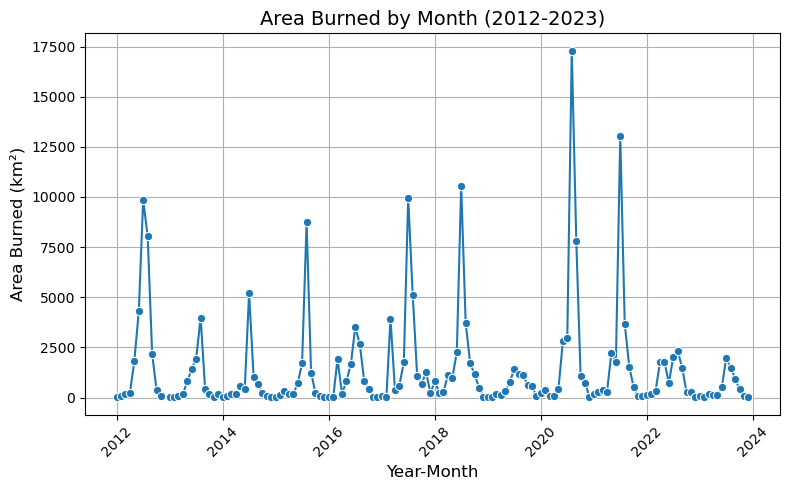

In [18]:
# Create a new column for 'year-month'
events_west_['ig_date'] = pd.to_datetime(events_west_['ig_date'])
events_west_['year_month'] = events_west_['ig_date'].dt.to_period('M')
# Aggregate the total area burned ('tot_ar_km2') by 'year_month'
monthly_area_burned = events_west_.groupby('year_month')['tot_ar_km2'].sum().reset_index()
# Convert 'year_month' back to a datetime format for plotting
monthly_area_burned['year_month'] = monthly_area_burned['year_month'].dt.to_timestamp()

# Plotting the time-series
plt.figure(figsize=(8, 5))
sns.lineplot(x='year_month', y='tot_ar_km2', data=monthly_area_burned, marker='o')
plt.title('Area Burned by Month (2012-2023)', fontsize=14)
plt.xlabel('Year-Month', fontsize=12)
plt.ylabel('Area Burned (km²)', fontsize=12)
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()

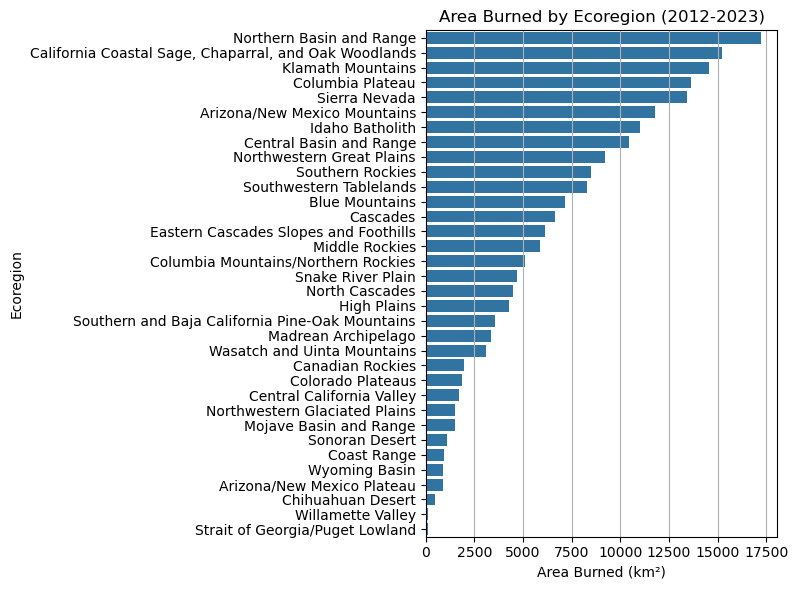

In [19]:
# Aggregate total burned area by ecoregion
eco_burned_area = events_west_.groupby('na_l3name')['tot_ar_km2'].sum().reset_index()

# Sort the data by total burned area in descending order
eco_burned_area = eco_burned_area.sort_values(by='tot_ar_km2', ascending=False)

# Plot the bar chart
plt.figure(figsize=(8, 6))
sns.barplot(x='tot_ar_km2', y='na_l3name', data=eco_burned_area)
plt.title('Area Burned by Ecoregion (2012-2023)', fontsize=12)
plt.xlabel('Area Burned (km²)', fontsize=10)
plt.ylabel('Ecoregion', fontsize=10)
plt.grid(True, axis='x')
plt.tight_layout()

# Show the plot
plt.show()

In [20]:
gc.collect()

3962